# DL homework №2: LM on сharacter-level LSTM
### Выполнил студент 317 группы ВМК МГУ Суглобов Кирилл

В этой работе сконструируем LM на базе LSTM, используя посимвольное (character-level) кодирование: сеть будет обучаться символ за символом по некоторому тексту, а затем генерировать новый текст также символ за символом. В качестве данных для обучения возьмём распространённый для подобного исследования датасет, "Анну Каренину" Л. Н. Толстого. Подберём наилучшие гиперпараметры для модели, оценим качество текста, который модель сгенерирует на основе фраз из книги.

Ниже представлен общий вид архитектуры символьной RNN:

<img src="assets/charseq.jpeg" width="500">

## Импорты

In [1]:
#!g1.1
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm

from time import time

import matplotlib.pyplot as plt

In [2]:
#!g1.1
%load_ext autoreload
%autoreload 2

---
## Загрузка данных

Загрузим корпус для обучения:

In [3]:
#!g1.1
with open('data/anna_karenina.txt', 'r') as f:
    text = f.read()

Посмотрим на первые 100 символов текста:

In [4]:
#!g1.1
text[:100]

'Лев Николаевич Толстой\n\nАнна Каренина\n\nМне отмщение, и аз воздам\n\nЧАСТЬ ПЕРВАЯ\n\nI\n\n   Все счастливые'

Токенизируем данные для обучения, переведём текст в числа:

In [5]:
#!g1.1
# encode the text and map each character to an integer and vice versa

# we create two dictonaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers

# all chars
chars = tuple(set(text))

int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
data = np.array([char2int[ch] for ch in text])

Те же 100 первых символов корпуса для обучения, но закодированные:

In [6]:
#!g1.1
data[:100]

array([131,  34,   4,  70,  50,  67,  32,  10, 113,  94,  34,   4,  67,
        75,  70, 120,  10, 113,  57,  19,  10, 134,  44,  44,  82, 118,
       118,  94,  70,  71,  94,  78,  34, 118,  67, 118,  94,  44,  44,
        91, 118,  34,  70,  10,  19, 112, 111,  34, 118,  67,  34,  89,
        70,  67,  70,  94,  66,  70,   4,  10,  66,  15,  94, 112,  44,
        44,  38,  82,  56, 120, 110,  70,  60,  58, 121,  42,  82, 128,
        44,  44, 105,  44,  44,  70,  70,  70,  42,  57,  34,  70,  57,
        75,  94,  57,  19, 113,  67,   4,  61,  34])

## Предобработка данных

Как видно из архитектуры символьной RNN, на вход LSTM подаётся вектор, кодирующий какой-либо символ. То есть каждый символ кодируется числом, которое, в свою очередь, кодируется уникальным вектором, где только по индексу, соответствующему этому числу, будет $1$, а на всех остальных позициях будет $0$. Воспользуемся для этого быстрым кодированием (One-Hot Encoding).


In [7]:
#!g1.1
from lab_utils import one_hot_encode

Также создадим мини-батчи, которые представляют собой несколько последовательностей, состоящих нескольких шагов: каждый батч представляет собой матрицу закодированных символов `n_seqs` $\times$ `n_steps` (batch size = `n_seqs`). Сначала вся последовательность данных нацело делится на `n_seqs` строк (во всех сроках число символов равное, кроме последней, там может быть меньше). Далее по полученной "матрице" (по выстроенным одна под другой `n_seqs` строкам) проходимся окном `n_seqs` $\times$ `n_steps` (sequence length = `n_steps`). Таким образом получаем батчи из закодированных данных (по сути это `n_seqs` последовательностей закондированных символов каждая длиной `n_steps`), к которым мы далее применяем one-hot encoding и подаём на вход сети. Это входные данные, а таргеты - это те же символы, но сдвинутые на одну позицию в тексте.

<img src="assets/sequence_batching.png" width=500px>

In [8]:
#!g1.1
from lab_utils import get_batches

Пример формирования мини-батчей:

In [9]:
#!g1.1
n_seqs, n_steps = 10, 50
batches = get_batches(data, n_seqs, n_steps)
x, y = next(batches)

Размеры батчей:

In [10]:
#!g1.1
print(x.shape, y.shape)

(10, 50) (10, 50)


Срезы батчей $10 \times 10$:

In [11]:
#!g1.1
print(f'x: \n {x[:10, :10]}\n')
print(f'y: \n {y[:10, :10]}\n')

x: 
 [[131  34   4  70  50  67  32  10 113  94]
 [ 44  70  70  70 131  34   4  67 118  70]
 [ 66  15  94   4  94 113  70   4 118  94]
 [ 70  15  34 118  34  59  70  18  10 113]
 [  6  34 113  70  32  70  57  19  10 113]
 [ 67  66 118  64  70 112  10 127  70  19]
 [ 89  70  99  99  70  10  19   4  34  75]
 [118  70   9  66 118  94 113  70   4  57]
 [ 57  70 118  67 112  70  88  10  34  83]
 [  4  94  19  64  86  44  70  70  70  56]]

y: 
 [[ 34   4  70  50  67  32  10 113  94  34]
 [ 70  70  70 131  34   4  67 118  70  75]
 [ 15  94   4  94 113  70   4 118  94 134]
 [ 15  34 118  34  59  70  18  10 113  64]
 [ 34 113  70  32  70  57  19  10 113   9]
 [ 66 118  64  70 112  10 127  70  19  34]
 [ 70  99  99  70  10  19   4  34  75  94]
 [ 70   9  66 118  94 113  70   4  57 122]
 [ 70 118  67 112  70  88  10  34  83  94]
 [ 94  19  64  86  44  70  70  70  56  34]]



---
## Структура модели

Ниже изображена структура сети:

<img src="assets/charRNN.png" width=500px>

Сеть состоит из 3-х частей:
* LSTM-часть, с параметрами: входной размер (количество символов), размер скрытого слоя `n_hidden`, количество LSTM-слоев `n_layers`
* DropOut-часть (дропаут-слой), с одним параметром, вероятностью дропаута `drop_prob`.
* FC-часть (полносвязный слой), с параметрами: входной размер (размер скрытого слоя `n_hidden`) и выходной размер (количество символов).

При этом:
* Предсказания делаются с помощью Softmax-слоя после FC-части (FC-слой выдаёт распределение следующих символов для каждого входного). Для предсказания есть встроенная в сеть функция `predict`.
* Полносвязная часть инициализируется с помощью равномерного распределения $U \sim [-1, 1]$, а скрытые состояния инициализируются нулями.

Импортируем модель:

In [12]:
#!g1.1
from lab_model import MyLSTM

Импортируем функцию для обучения модели:

In [13]:
#!g1.1
from lab_utils import train_model

Импортируем функции для визуализации качества модели:

In [14]:
#!g1.1
from lab_vis import plot_loss
from lab_vis import plot_cv_losses

Вспомогательные функции:

In [15]:
#!g1.1
from lab_utils import time2format

---
## Обучение модели

Выставим стандартные гиперпараметры модели и создадим модель:

In [127]:
#!g1.1
n_hidden = 512
n_layers = 2
drop_prob = 0.7

In [91]:
#!g1.1
if 'net' in locals():
    del net

net = MyLSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)

net

MyLSTM(
  (lstm): LSTM(135, 512, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=512, out_features=135, bias=True)
)

Определим размеры мини-батчей и параметры обучения и запустим обучение (переброс модели на GPU и обратно спрятан во флаге `cuda=True`):

In [135]:
#!g1.1
n_seqs = 128
n_steps = 100

n_epochs = 25
opt = 'Adam'
lr = 0.001

In [94]:
#!g1.1
train_loss, val_loss = train_model(net, data, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps, opt=opt, lr=lr, cuda=True, print_every=10)

100%|██████████| 25/25 [06:50<00:00, 16.41s/it]


Для оценки качества модели используем кросс-энтропию:

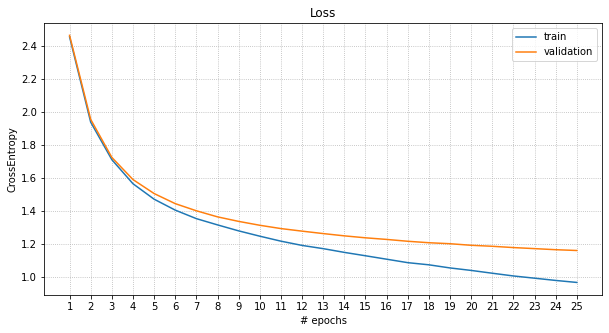

In [95]:
#!g1.1
plot_loss('Loss', n_epochs, train_loss, val_loss)

---
## Лучшая модель

Оставим параметры, отвечающие за размеры мини-батчей и за обучение, стандартными, только уменьшим число эпох. Подберём гиперпараметры самой модели:
* Размерность скрытого представления `n_hidden`
* Число скрытых слоёв `n_layers`
* Вероятность дропаута `drop_prob`

Сделаем перебор следующим образом: при фиксированной размерности скрытого слоя будем смотреть качество на валидации (и на обучении тоже выведем) в зависимости от числа слоёв на нескольких кривых для различных вероятностей дропаута.
Гиперпараметры будем перебирать по множествам:
* `n_hidden` $\in \{4, 32, 64, 128, 256, 512, 1024\}$
* `n_layers` $\in \{2, 3, 4, 6\}$
* `drop_prob` $\in \{0, 0.1, 0.25, 0.5, 0.7\}$

In [262]:
#!g1.1
n_seqs = 128
n_steps = 100

n_epochs = 10
opt = 'Adam'
lr = 0.001

n_layers_arr = np.array([2, 3, 4, 6])
drop_prob_arr = np.array([0, 0.1, 0.25, 0.5, 0.7])

Так как одна модель обучается не очень долго, то не будем сохранять каждую модель для экономии места.

Найдём **лучшие** гиперпараметры и повторно обучим с ними модель, её и сохраним.

Для удобного замера контроля выполнения кросс-валидации будем выводить текущее `n_hidden` и `n_layers` модели, последнее вместе с прошедшим временем

Сначала попробуем не очень большие `n_hidden`:

In [263]:
#!g1.1
n_hidden_arr = np.array([4, 32, 64, 128, 256])

In [250]:
#!g1.1
start_time = time()

train_losses = np.zeros((n_hidden_arr.size, n_layers_arr.size, drop_prob_arr.size))
val_losses = np.zeros_like(train_losses)

for i, n_hidden in enumerate(n_hidden_arr):
    print(f'===n_hidden={n_hidden}')
    for j, n_layers in enumerate(n_layers_arr):
        for k, drop_prob in enumerate(drop_prob_arr):
            # creating model
            if 'net' in locals():
                del net
            net = MyLSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)

            # training model
            train_loss, val_loss = train_model(net, data, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps,
                                               opt=opt, lr=lr, cuda=True, print_every=10, tqdm_print=False)
            
            # saving losses
            train_losses[i][j][k] = train_loss[-1]
            val_losses[i][j][k] = val_loss[-1]

        print(f'  n_layers={n_layers}, time passed: {time2format(time() - start_time)}')

===n_hidden=4
  n_layers=2, time passed: 00:05:42
  n_layers=3, time passed: 00:12:56
  n_layers=4, time passed: 00:21:42
  n_layers=6, time passed: 00:33:30
===n_hidden=32
  n_layers=2, time passed: 00:40:39
  n_layers=3, time passed: 00:49:55
  n_layers=4, time passed: 01:01:19
  n_layers=6, time passed: 01:16:44
===n_hidden=64
  n_layers=2, time passed: 01:24:41
  n_layers=3, time passed: 01:35:05
  n_layers=4, time passed: 01:48:07
  n_layers=6, time passed: 02:06:09
===n_hidden=128
  n_layers=2, time passed: 02:15:00
  n_layers=3, time passed: 02:26:44
  n_layers=4, time passed: 02:41:15
  n_layers=6, time passed: 03:01:20
===n_hidden=256
  n_layers=2, time passed: 03:10:23
  n_layers=3, time passed: 03:22:26
  n_layers=4, time passed: 03:37:27
  n_layers=6, time passed: 03:58:31


In [264]:
#!g1.1
np.save('saved/cv_train_losses_part1.npy', train_losses)
np.save('saved/cv_val_losses_part1.npy', val_losses)

И отдельно попробуем особо большие `n_hidden`:

In [265]:
#!g1.1
n_hidden_arr2 = np.array([512, 1024])

In [266]:
# !g1.1
start_time = time()

train_losses2 = np.zeros((n_hidden_arr2.size, n_layers_arr.size, drop_prob_arr.size))
val_losses2 = np.zeros_like(train_losses2)

for i, n_hidden in enumerate(n_hidden_arr2):
    print(f'===n_hidden={n_hidden}')
    for j, n_layers in enumerate(n_layers_arr):
        for k, drop_prob in enumerate(drop_prob_arr):
            # creating model
            if 'net' in locals():
                del net
            net = MyLSTM(chars, n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)

            # training model
            train_loss, val_loss = train_model(net, data, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps,
                                               opt=opt, lr=lr, cuda=True, print_every=10, tqdm_print=False)
            
            # saving losses
            train_losses2[i][j][k] = train_loss[-1]
            val_losses2[i][j][k] = val_loss[-1]

        print(f'  n_layers={n_layers}, time passed: {time2format(time() - start_time)}')

===n_hidden=512
  n_layers=2, time passed: 00:13:59
  n_layers=3, time passed: 00:32:58
  n_layers=4, time passed: 00:57:38
  n_layers=6, time passed: 01:34:27
===n_hidden=1024
  n_layers=2, time passed: 02:12:52
  n_layers=3, time passed: 03:12:29
  n_layers=4, time passed: 04:33:52
  n_layers=6, time passed: 06:38:56


In [267]:
#!g1.1
np.save('saved/cv_train_losses_part2.npy', train_losses2)
np.save('saved/cv_val_losses_part2.npy', val_losses2)

Теперь загрузим сохранённые в двух частях результаты:

In [268]:
#!g1.1
train_losses1 = np.load('saved/cv_train_losses_part1.npy')
val_losses1 = np.load('saved/cv_val_losses_part1.npy')

train_losses2 = np.load('saved/cv_train_losses_part2.npy')
val_losses2 = np.load('saved/cv_val_losses_part2.npy')

Объединим обе части подбора гиперпараметров, сохраним их:

In [273]:
#!g1.1
train_losses = np.vstack([train_losses1, train_losses2])
val_losses = np.vstack([val_losses1, val_losses2])

In [274]:
#!g1.1
np.save('saved/cv_train_losses_final.npy', train_losses)
np.save('saved/cv_val_losses_final.npy', val_losses)

**Загружаем финальные результаты подбора гиперпараметров модели**:

In [16]:
#!g1.1
train_losses = np.load('saved/cv_train_losses_final.npy')
val_losses = np.load('saved/cv_val_losses_final.npy')

Обновим сетки гиперпараметров до финальных (объединим из обеих частей):

In [17]:
#!g1.1
n_hidden_arr = np.array([4, 32, 64, 128, 256, 512, 1024])
n_layers_arr = np.array([2, 3, 4, 6])
drop_prob_arr = np.array([0, 0.1, 0.25, 0.5, 0.7])

### Качество моделей

Выведем графики качества всех перебранных моделей:

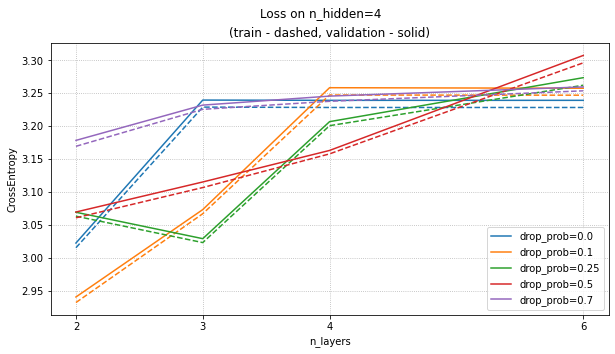

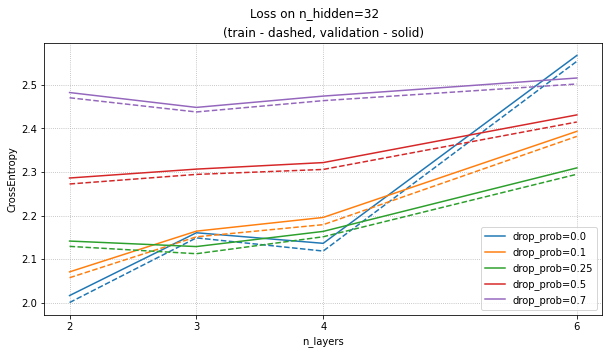

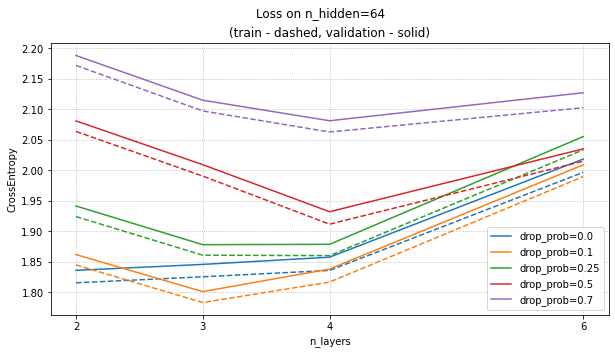

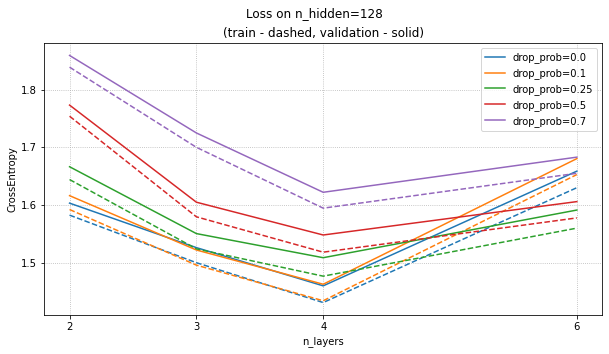

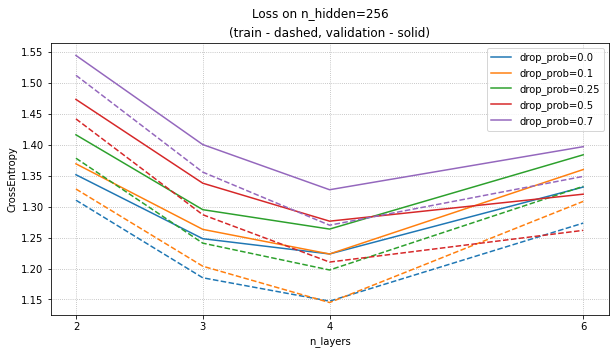

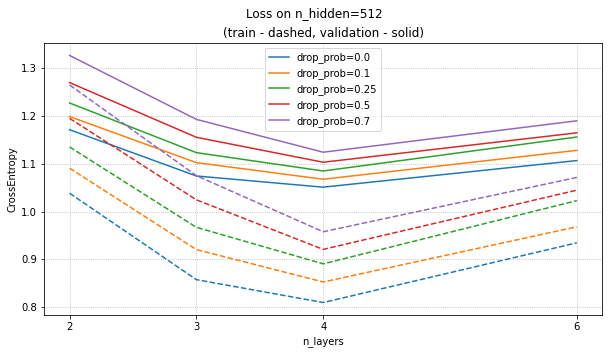

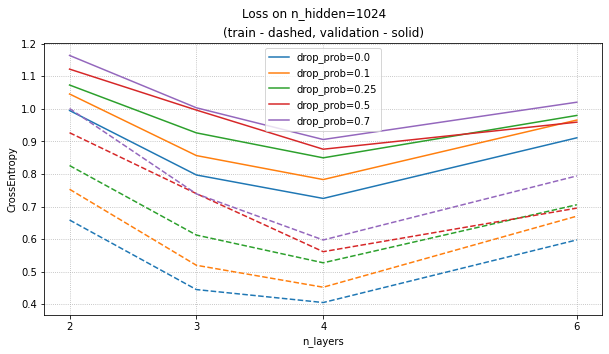

In [284]:
#!g1.1
drop_prob_labels = [f'drop_prob={drop_prob}' for drop_prob in drop_prob_arr]
for i, n_hidden in enumerate(n_hidden_arr):
    plot_cv_losses(f'Loss on n_hidden={n_hidden}', 'n_layers',
                   train_losses[i], val_losses[i],
                   n_layers_arr, drop_prob_labels)

Из графиков видно, что при увеличении размеров модели, это видно при варьировании параметра `n_hidden`, у сеть, естественно, начинает расти переобучение: график за графиком функция на каждой бОльшей модели потери на обучении всё более удаленные (в меньшую сторону) от потерь на валидации. И регуляризация дропаутом не проявляет себя хорошо, начиная с модели с `n_hidden=128`. Видимо, для подобных размеров модели недостаточно эпох обучения: подбор параметров проводился на обученных всего на 10 эпох моделях. А лучшее качество достигается как раз на больших моделях, в данном случае на самой большой по параметру `n_hidden`. Итак, выделим лучшую модель:

Напомним три сетки параметров, по которым мы перебирали:

In [18]:
#!g1.1
print(f'1. n_hidden is from {list(n_hidden_arr)}')
print(f'2. n_layers is from {list(n_layers_arr)}')
print(f'3. drop_prob is from {list(drop_prob_arr)}')

1. n_hidden is from [4, 32, 64, 128, 256, 512, 1024]
2. n_layers is from [2, 3, 4, 6]
3. drop_prob is from [0.0, 0.1, 0.25, 0.5, 0.7]


Исходя из полученного качества на кросс-валидации выберем лучшую по качеству на валидации модель:

In [19]:
#!g1.1
grids = [n_hidden_arr, n_layers_arr, drop_prob_arr]
grids_name = ['n_hidden', 'n_layers', 'drop_prob']

best_params = [arr[i] for i, arr in zip(np.unravel_index(val_losses.argmin(), val_losses.shape), grids)]
best_params_dict = {arr_name: param for param, arr_name in zip(best_params, grids_name)}
print(f'best params: {best_params_dict}')

best params: {'n_hidden': 1024, 'n_layers': 4, 'drop_prob': 0.0}


### Результат

Обучим модель с лучшими гиперпараметрами на стандартных параметрах обучения (стандартный размер батча и оптимизация), только увеличим количество эпох:

In [22]:
#!g1.1
if 'net' in locals():
    del net

net = MyLSTM(chars, **best_params_dict)
net

MyLSTM(
  (lstm): LSTM(135, 1024, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=1024, out_features=135, bias=True)
)

In [23]:
#!g1.1
n_seqs = 128
n_steps = 100

n_epochs = 30
opt = 'Adam'
lr = 0.001

In [24]:
#!g1.1
train_loss, val_loss = train_model(net, data, epochs=n_epochs, n_seqs=n_seqs, n_steps=n_steps, opt=opt, lr=lr, cuda=True, print_every=10)

100%|██████████| 30/30 [48:46<00:00, 97.56s/it]


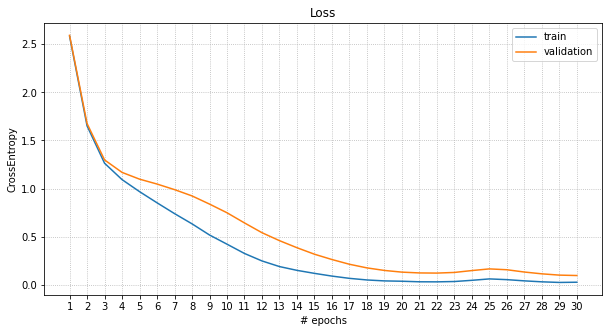

In [25]:
#!g1.1
plot_loss('Loss', n_epochs, train_loss, val_loss)

По графику и значениям на нём можно предположить, что модель хорошо обучилась. На 18-30 эпохах видно некое подобие эффекта двойного спуска: переобучение возрастает, а после пика уменьшается. Но, кажется, это на уровне погрешности.

In [31]:
#!g1.1
print(f'Final loss (CrossEntropy) on train/validation: {train_loss[-1]:.4f}/{val_loss[-1]:.4f}')

Final loss (CrossEntropy) on train/validation: 0.0262/0.0958


Сохраним итоговую модель:

In [17]:
#!g1.1
model_name = 'best_model.pt'

In [34]:
#!g1.1
checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'drop_prob': net.drop_prob,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(f'saved/{model_name}', 'wb') as f:
    torch.save(checkpoint, f)

Загрузим модель:

In [18]:
#!g1.1
with open(f'saved/{model_name}', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = MyLSTM(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'], drop_prob=checkpoint['drop_prob'])
loaded.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [19]:
#!g1.1
net = loaded

---
## Сэмплирование

Теперь, когда модель обучена, осталось сэмплировать из неё. Для этого сети подаётся символ, и она предсказывает следующий символ. После чего он возвращается ей же - таким образом продолжается до момента, пока не получим текст нужной длины.

Воспользуемся **top-k-сэмплированием**.

Прогноз следующего символа основан на вероятностном выборе одного символа из всего выхода сети. Но мы можем выходные ограничить символы сети, из которых мы случайным образом можем выбрать следующий: взять top-k наиболее вероятных символов (то есть с наибольшей вероятностью) и выбирать уже только из них. Частным случаем top-k-сэмплирования является жадное сэмплирование, когда мы в качестве следующего символа берём самый вероятный символ, что эквивалентно top-1-сэмплированию.

Top-k-сэмплирование не позволит сети выдавать нам совершенно абсурдные символы, в то же время позволяя ей вносить некоторый шум и хаотичность в выборку текста. Обычно такой подход улучшает качество, удаляя "хвост" и уменьшая вероятность отклонения от "правильных" символов.

Сгенерируем текст как с top-k-сэмплированием, так и без него, по всем вероятностям: последнее помечено как `k=None`.

**Сэмплируем:**

In [30]:
#!g1.1
from lab_utils import sample

Зададим длину генерируемого текста `length`, начало текста `prime` и сетку top-k `k_arr`:

In [91]:
#!g1.1
length = 500
prime = 'Вечером он'
k_arr = [None] + list(range(1, 11))

In [92]:
#!g1.1
for k in k_arr:
    gen_text = sample(net, length, prime=prime, top_k=k, cuda=True)
    print(f'=====|k={k}|=====\n'
          f'{gen_text}\n')

=====|k=None|=====
Вечером он представлял себе переговорить о жене.
   -- Вам четырь между мной и государен; но мне нужно поговорить о грустном для вас деле. Я все бы дала, чтоб избавить вас от некоторых воспоминаний, не оставив следа за вас теорикования -- прелесть! -- закричал Петрицкий... -- Ведь его страсть -- балы, и он ни одного придворного бала не пропускает. Отправился он на большой бал в новой каске. Ты видел новые каски? Очень хороши, легче. Только стоит он... Нет, ткак немножко ковест все знают эти ужасы.
   -- И 

=====|k=1|=====
Вечером он представлялся себе Анну в том же самом положении, которое он так ясно видел и не любил в других и за которое он упрекал приятеля своего Свияжского.
   Проводя этот вечер с невестой у Долли, Левин был особенно веселый и враждебным к этому открытую статью и свежую ногу, столь полковнють другие крайние в то время, как он надевал шубу и дружески разговаривал с губернским предводителем. Левин пришел в себе и получать два часа, Левин вышел на 

По результатам сэмплирования кажется, что самые качественные тексты получаются при `k` $\in {3, 4, 5}$.
А при отсутствии отбора top-k, то есть при сэмплировании по всем вероятностям, `k=None`, видно, что в тексте присутствуют "шумы": встречаются маловероятные последовательности символов, которые мы как раз "отрезаем" с помощью top-k-сэмплирования.

In [88]:
#!g1.1
length = 500
prime = 'Последний раз'
k_arr = list(range(3, 6))

In [89]:
#!g1.1
for k in k_arr:
    gen_text = sample(net, length, prime=prime, top_k=k, cuda=True)
    print(f'=====|k={k}|=====\n'
          f'{gen_text}\n')

=====|k=3|=====
Последний раз? -- сказал Вронский. -- Хуже.
   -- Да скоро"?
   -- подхватил тут.
   Партия не обратилось к нему.
   -- Скорее женилов. И эти отношения могут установиться только свободой обеих сторон.
   -- Развод, -- с отвращением перебил Алексей Александрович.
   -- Как можно быть равнодушным! -- сказала Лидия Ивановна.
   -- Я в этом отношения не то что равнодушен, но в ожидании, -- сказал Степан Аркадьич с своею самою смягчающею улыбкой. -- Я не думаю, чтобы для меня наступило время этого положения! Я пол

=====|k=4|=====
Последний раз? Отвечая в своей голове на столине и, сказав "на, простить, а скучно. А я хотел к вам ехать. Только что хотелиеь погубить ее. Подав приятное чувство, -- прибавил он у кро-- входил в сарай. -- Что, И я поеду в один губернии.
   -- Но все-таки совестно и ужасно.
   -- "le, st t-mu, la femr enо" -- подумал Алексей Александрович.
   -- Да, да! -- вскрикнул он визгливым голосом, -- я беру на себя позор, отдаю даже сына, но... -- но не лучш

Интересно получилось в последнем примере с `k=5`, где фраза "последний раз" дополнилась до "Последний разговор". В том числе и в этом можно увидеть увеличение вариативности генерируемого текста (разнообразие следующего символа) при увеличении top_k.

Таким образом, **оптимальные параметры сэмплирования**: top-k-сэмплирование при `k` $\in {3, 4, 5}$.

---
## Выводы

Таким образом, обучаясь на корпусе текстов - романе Л. Н. Толстого "Анна Каренина" - была создана языковая модель на базе LSTM с посимвольным кодированием. Были подобраны лучшие гиперпараметры (по выбранным сеткам) модели, обеспечивающие наибольшее качество решения (по кросс-энтропии). И при оптимальных параметрах сэмплирования генерируемый сетью текст получается читабельным, достаточно осмысленным и без несуществующих слов.

### Замечания

Стоило бы также:
* **перебрать параметры** обучения: `n_seqs` и `n_steps`, отвечающие за размер батча, и `opt` (`Adam` или `SGD`) и `lr`, отвечающие за оптимизацию функции потерь.
* **увеличить число эпох обучения** итоговой модели с 30-ти, например до 50-ти.
* попробовать **больше способов сэмплирования**, например Beam Search и Nucleus Sampling.

В заключение: подбор гиперпараметров модели занял около 10.5 часов, а потребление мощностей на выполнение этой домашней работы на одной Tesla V100 стоило около 4800 руб.,

так что стипендии на домашку не хватило)